In [1]:
#ref - https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings

# Basic Libs..
import multiprocessing
from multiprocessing.pool import ThreadPool
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from tqdm import tqdm,tqdm_notebook
from prettytable import PrettyTable
import pickle
import shutil
import os
print('CWD is ',os.getcwd())

# Vis Libs..
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.grid"] = False

# Image Libs.
from PIL import Image
import cv2

# sklearn libs..
from sklearn.model_selection import train_test_split

# DL Libs..
import keras
from keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,array_to_img,load_img
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

CWD is  F:\Train


In [2]:
# Visualization
def load_data():
    train = pd.read_csv(r"F:\Train\train.csv")
    
    train_dir = os.path.join(r"F:\Train\train_images")
    
    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
    
    train['file_name'] = train['id_code'].apply(lambda x: x + ".png")
    
    train['diagnosis'] = train['diagnosis'].astype(str)
    
    return train

In [3]:
df_train = load_data()
print(df_train.shape)
print(df_train.head(6))

(3662, 4)
        id_code diagnosis                               file_path  \
0  000c1434d8d7         2  F:\Train\train_images\000c1434d8d7.png   
1  001639a390f0         4  F:\Train\train_images\001639a390f0.png   
2  0024cdab0c1e         1  F:\Train\train_images\0024cdab0c1e.png   
3  002c21358ce6         0  F:\Train\train_images\002c21358ce6.png   
4  005b95c28852         0  F:\Train\train_images\005b95c28852.png   
5  0083ee8054ee         4  F:\Train\train_images\0083ee8054ee.png   

          file_name  
0  000c1434d8d7.png  
1  001639a390f0.png  
2  0024cdab0c1e.png  
3  002c21358ce6.png  
4  005b95c28852.png  
5  0083ee8054ee.png  


In [4]:
'''This Function Plots a Bar plot of output Classes Distribution'''

def plot_classes(df,title):
    df_group = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['diagnosis','count']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'diagnosis',y='count',data = df_group,palette = "Blues_d")
    plt.title('Output Class Distribution ' + str(title))
    plt.show() 

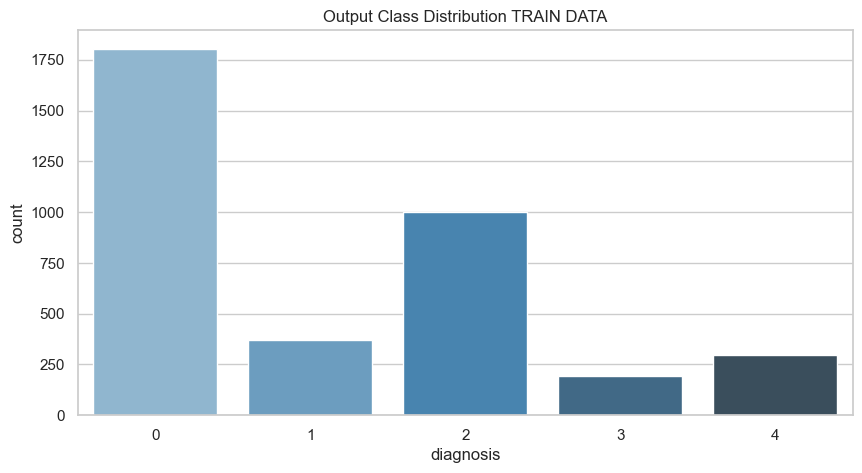

In [5]:
plot_classes(df_train,"TRAIN DATA")

In [6]:

file = open('df_train', 'wb')
pickle.dump(df_train, file)
file.close()

In [7]:
file = open('df_train', 'rb')
df_train_train = pickle.load(file)
file.close()

In [8]:
IMG_SIZE  = 512

In [9]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def circle_crop(img, sigmaX = 30):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

'''Function loads an image from Folder , Resizes and saves in another directory '''

# Input and output folder paths
input_folder = r"F:\Train\train_images"
output_folder = r"F:\Train\train_resize"

# Ensure the output folder exists, create it if necessary
os.makedirs(output_folder, exist_ok=True)

# Iterate over each file in the input folder
for filename in os.listdir(input_folder):
    # Construct the input and output file paths
    input_filepath = os.path.join(input_folder, filename)
    output_filepath = os.path.join(output_folder, filename)

    # Load the image
    image = cv2.imread(input_filepath)

    # Check if the image was loaded successfully
    if image is None:
        print("Error: Unable to load image from", input_filepath)
        continue

    # Resize the image to desired dimensions (e.g., 256x256)
    resized_image = cv2.resize(image, (512, 512))

    # Save the resized image to the output folder
    cv2.imwrite(output_filepath, resized_image)

    print("Resized image saved to", output_filepath)

def preprocess_image(file):
    input_filepath = os.path.join(r'F:\Train\train_images','{}.png'.format(file))
    output_filepath = os.path.join(r'F:\Train\train_resize'.format(file))
    
    img = cv2.imread(input_filepath)
    img = circle_crop(img) 
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))

Resized image saved to F:\Train\train_resize\000c1434d8d7.png
Resized image saved to F:\Train\train_resize\001639a390f0.png
Resized image saved to F:\Train\train_resize\0024cdab0c1e.png
Resized image saved to F:\Train\train_resize\002c21358ce6.png
Resized image saved to F:\Train\train_resize\005b95c28852.png
Resized image saved to F:\Train\train_resize\0083ee8054ee.png
Resized image saved to F:\Train\train_resize\0097f532ac9f.png
Resized image saved to F:\Train\train_resize\00a8624548a9.png
Resized image saved to F:\Train\train_resize\00b74780d31d.png
Resized image saved to F:\Train\train_resize\00cb6555d108.png
Resized image saved to F:\Train\train_resize\00cc2b75cddd.png
Resized image saved to F:\Train\train_resize\00e4ddff966a.png
Resized image saved to F:\Train\train_resize\00f6c1be5a33.png
Resized image saved to F:\Train\train_resize\0104b032c141.png
Resized image saved to F:\Train\train_resize\0124dffecf29.png
Resized image saved to F:\Train\train_resize\0125fbd2e791.png
Resized 